<a href="https://colab.research.google.com/github/TarnaiMark/AdvStat/blob/main/halstat_survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises

In [3]:
!pip install lifelines scikit-survival

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 15.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4120 sha256=13d863febdee6f633a6d5be9f3336f6488d7a052a742bed81a286fe42b4b8c9a
  Stored in directory: /home/codespace/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import lifelines as lf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## 0.) Pre-processing

Load the <i><a href="https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.datasets.load_veterans_lung_cancer.html">Veteran's Lung Cancer</a></i> dataset from <code>scikit-survival</code>! Note that it returns a <code>Pandas</code> DataFrame of the features, and a structured array containing the survival times, and censoring status.

In [16]:
from sksurv.datasets import load_veterans_lung_cancer
df,y = load_veterans_lung_cancer()
print(y.dtype)

[('Status', '?'), ('Survival_in_days', '<f8')]


Add the survival time and censoring status to the DataFrame as new columns!

In [17]:
df['survival_time'] = y['Survival_in_days']
df['censoring_status'] = y['Status']
df.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment,survival_time,censoring_status
0,69.0,squamous,60.0,7.0,no,standard,72.0,True
1,64.0,squamous,70.0,5.0,yes,standard,411.0,True
2,38.0,squamous,60.0,3.0,no,standard,228.0,True
3,63.0,squamous,60.0,9.0,yes,standard,126.0,True
4,65.0,squamous,70.0,11.0,yes,standard,118.0,True


Take a look at the features! What kind of features do you see?

In [21]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Age_in_years           137 non-null    float64 
 1   Celltype               137 non-null    category
 2   Karnofsky_score        137 non-null    float64 
 3   Months_from_Diagnosis  137 non-null    float64 
 4   Prior_therapy          137 non-null    category
 5   Treatment              137 non-null    category
 6   survival_time          137 non-null    float64 
 7   censoring_status       137 non-null    bool    
dtypes: bool(1), category(3), float64(4)
memory usage: 5.4 KB


,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment,survival_time,censoring_status
count,137.000000,137,137.000000,137.000000,137,137,137.000000,137
unique,NaN,4,NaN,NaN,2,2,NaN,2
top,NaN,smallcell,NaN,NaN,no,standard,NaN,True
freq,NaN,48,NaN,NaN,97,69,NaN,128
mean,58.306569,NaN,58.569343,8.773723,NaN,NaN,121.627737,NaN
std,10.541628,NaN,20.039592,10.612141,NaN,NaN,157.816722,NaN
min,34.000000,NaN,10.000000,1.000000,NaN,NaN,1.000000,NaN
25%,51.000000,NaN,40.000000,3.000000,NaN,NaN,25.000000,NaN
50%,62.000000,NaN,60.000000,5.000000,NaN,NaN,80.000000,NaN
75%,66.000000,NaN,75.000000,11.000000,NaN,NaN,144.000000,NaN


Use one-hot-encoding on the categorical features!

Hint: [<code>pd.get_dummies(drop_first=True)</code>](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

In [22]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,Age_in_years,Karnofsky_score,Months_from_Diagnosis,survival_time,censoring_status,Celltype_large,Celltype_smallcell,Celltype_squamous,Prior_therapy_yes,Treatment_test
0,69.0,60.0,7.0,72.0,True,False,False,True,False,False
1,64.0,70.0,5.0,411.0,True,False,False,True,True,False
2,38.0,60.0,3.0,228.0,True,False,False,True,False,False
3,63.0,60.0,9.0,126.0,True,False,False,True,True,False
4,65.0,70.0,11.0,118.0,True,False,False,True,True,False


Scale the the numeric features (except for the survival time) to have zero mean and unit variance!

Hint: [`sklearn.preprocessing.scale`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html)

In [23]:
from sklearn.preprocessing import scale
numeric_features = df_encoded.select_dtypes(include=['float64', 'int64']).drop(columns=['survival_time'])
scaled_features = scale(numeric_features)
df_scaled = pd.DataFrame(scaled_features, columns=numeric_features.columns)
df_scaled['survival_time'] = df_encoded['survival_time']
df_scaled['censoring_status'] = df_encoded['censoring_status']
df_scaled.head()

,Age_in_years,Karnofsky_score,Months_from_Diagnosis,survival_time,censoring_status
0,1.018123,0.071654,-0.167754,72.0,True
1,0.542072,0.572497,-0.356909,411.0,True
2,-1.933391,0.071654,-0.546064,228.0,True
3,0.446862,0.071654,0.021401,126.0,True
4,0.637282,0.572497,0.210556,118.0,True


## 1.) Kaplan-Meier estimator

Stratify the population according to some rule! This could be based on categories or numerical features. Calculate the Kaplan-Meier estimator (<code style="font-size:9px;"><a href="https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html">lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter</a></code>) for each group and plot the results. Do the plots seem to show any differences?

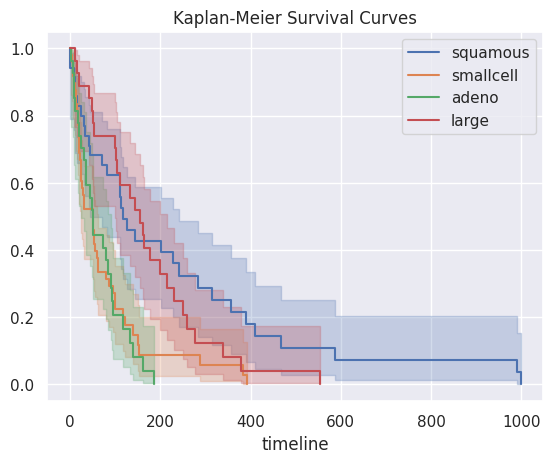

In [25]:
from lifelines import KaplanMeierFitter

# Stratify by a categorical feature (e.g., 'Celltype')
groups = df['Celltype']
kmf = KaplanMeierFitter()

for group in groups.unique():
    mask = groups == group
    kmf.fit(df['survival_time'][mask], event_observed=df['censoring_status'][mask], label=str(group))
    kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curves")
plt.show()

Perform a logrank test to see whether these splits are meaningful. You can use <code style="font-size:9px;"><a href="https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html#lifelines.statistics.logrank_test">lifelines.statistics.logrank_test</a></code>.





In [27]:
from lifelines.statistics import logrank_test

group1 = df['survival_time'][df['Celltype'] == 'squamous']
group2 = df['survival_time'][df['Celltype'] == 'large']
event1 = df['censoring_status'][df['Celltype'] == 'squamous']
event2 = df['censoring_status'][df['Celltype'] == 'large']

results = logrank_test(group1, group2, event_observed_A=event1, event_observed_B=event2)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.82 0.36      1.46

Heed the advice in the lifelines docs and repeat the testing with likelihood ratio test. Are the splits still meaningful? Fit a Cox proportional hazards model on a binary indicator of group membership. If the corresponding coefficient is confirmed by the likelihood ratio test to be non-zero, that means the grouping is meaningful.

In [34]:
from lifelines import CoxPHFitter

# Create a binary indicator for group membership (e.g., squamous vs. large)
df['group'] = (df['Celltype'] == 'squamous').astype(int)

# Fit a Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(df[['survival_time', 'censoring_status', 'group']], duration_col='survival_time', event_col='censoring_status')
cph.print_summary()

# Perform a likelihood ratio test
lr_test = cph.log_likelihood_ratio_test()
print("Likelihood Ratio Test p-value:", lr_test.p_value)

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'survival_time'
                event col = 'censoring_status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -499.76
         time fit was run = 2025-05-12 12:08:52 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
group     -0.71      0.49      0.22           -1.15           -0.28                0.32                0.76

           cmp to     z      p  -log2(p)
covariate                               
group        0.00 -3.19 <0.005      9.47
---
Concordance = 0.55
Partial AIC = 1001.52
log-likelihood ratio test = 11.37 on 1 df
-log2(p) of ll-ratio test = 10.39

Likelihood Ratio Test p-value: 0.000744932863897544


## 2.)The Cox Proportional Hazards Model

Fit the [Cox proportional hazards model](https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html) to the preprocessed dataset! Plot the weights! According to them, which feature is the most influential?"

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'survival_time'
                event col = 'censoring_status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -484.39
         time fit was run = 2025-05-12 12:10:58 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
Age_in_years          -0.02      0.98      0.10           -0.21            0.16                0.81                1.18
Karnofsky_score       -0.67      0.51      0.10           -0.88           -0.47                0.42                0.63
Months_from_Diagnosis  0.01      1.01      0.09           -0.17            0.19                0.85                1.20

                       cmp to     z      p  -log2(p)
covariate                                           
Age_in_years             0.00 -0.25   0.80      0.32
Karnofsky_score          0.00 -6.43 <0.005     32.87
Months_from_Diagnosis    0.00  0.11   0.92      0.13
---
Concordance = 0.71
Partial AIC = 974.79
log-likelihood ratio test = 42.11 on 3 df
-log2(p) of ll-ratio test = 27.97

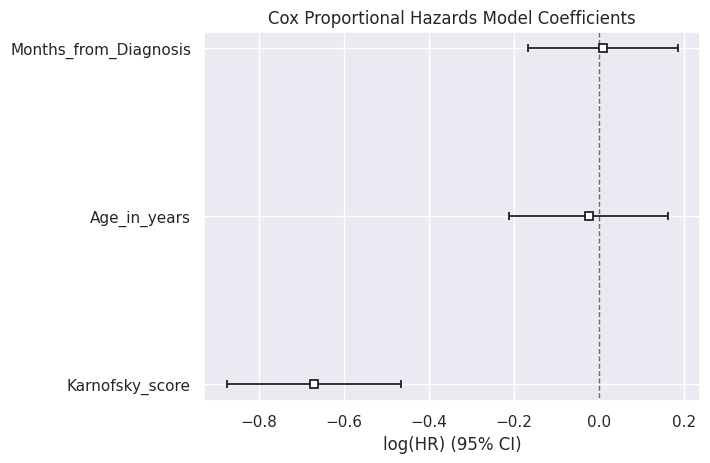

In [35]:
# Fit the Cox Proportional Hazards Model to the preprocessed dataset
cph = CoxPHFitter()
cph.fit(df_scaled, duration_col='survival_time', event_col='censoring_status')
cph.print_summary()

# Plot the coefficients (weights)
cph.plot()
plt.title("Cox Proportional Hazards Model Coefficients")
plt.show()

Is there any feature where the hypothesis for a zero coefficient cannot be discarded? Look at the Wald-test results!

Could these results be due to the data having some time-varying effect? Check the assumptions by using a 95% confidence interval and plotting the scaled Schoenfeld residuals!


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
         test_name = proportional_hazard_test

---
                            test_statistic      p  -log2(p)
Age_in_years          km              4.81   0.03      5.14
                      rank            4.96   0.03      5.27
Karnofsky_score       km             14.89 <0.005     13.10
                      rank           15.36 <0.005     13.45
Months_from_Diagnosis km              0.38   0.54      0.90
                      rank            0.31   0.58      0.80



1. Variable 'Age_in_years' failed the non-proportional test: p-value is 0.0260.

   Advice 1: the functional form of the variable 'Age_in_years' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age_in_years' using pd.cut, and then specify it in
`strata=['Age_in_years', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Karnofsky_score' failed the non-proportional test: p-value is 0.0001.

   Advice 1: the functional form of the variable 'Karnofsky_score' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect 

[[<Axes: xlabel='rank-transformed time\n(p=0.0260)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0283)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0001)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0001)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5761)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5351)'>]]

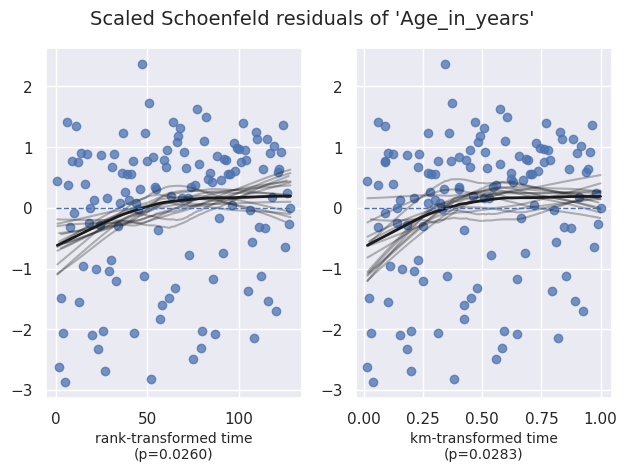

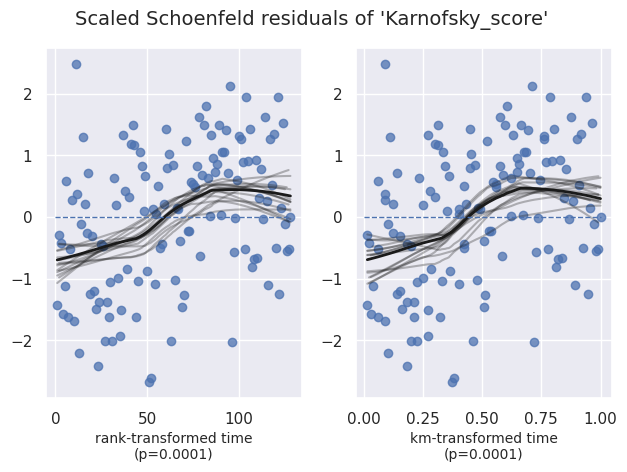

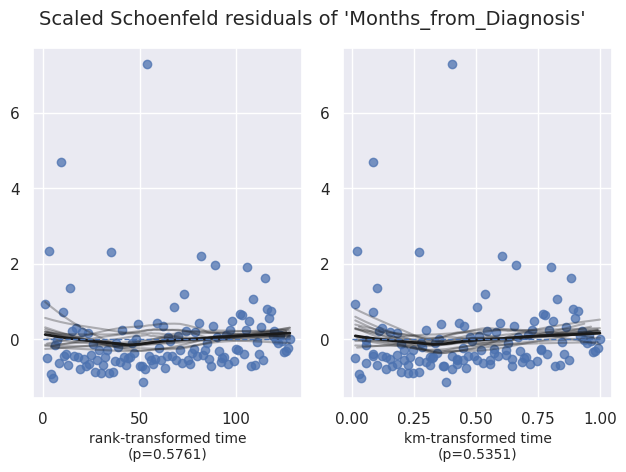

In [37]:
# Check the proportional hazards assumption and plot Schoenfeld residuals
cph.check_assumptions(df_scaled, p_value_threshold=0.05, show_plots=True)

Heed **Advice 2** and stratify the model. After stratification, each stratum will have its own CPH model that will hopefully satisfy the proportional hazards assumption.

Hint: Use [`pd.qcut`](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) to bin any numeric features according to the median (2-quantile).

## 3.) Concordance index
Unfortunetly Uno's IPC-weighted c-index is not implemented in lifelines, so we have to use the [scikit-survival implementation](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.metrics.concordance_index_ipcw.html). This also requires [`sksurv.utils.Surv`](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.util.Surv.html) to create the structured arrays, which are then passed on to the metric.

Calculate the c-index, for various truncation times in a 5-fold cross-validation scheme for both the stratified and unstratified models! What do you observe?

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw
from sklearn.model_selection import KFold

def concordance_index_ipcw_5fold_scorer(model,df,tau,**kwargs):

What do you think are the reasons for the results?